In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# **Import data from google drive**

d_{networkname}_s = the spatial data of average distance accross layers computed by the network

target = labels for each tiral, (1:right image is prefered, 0:left image is prefered)

In [3]:
d_vgg_s=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s_fully.npy',allow_pickle=True)
target=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_fully.npy')

In [4]:
left_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/left_img_data_fully.npy')
right_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/right_img_data_fully.npy')

Extracting and modify the data we are going to use in this experiment.

In [5]:
d_vgg_s_clean=[]
for d in d_vgg_s:
  d_vgg_s_clean.append(d.data.cpu().numpy().reshape(512,512))
del d_vgg_s

In [6]:
d_vgg_s_clean=np.array(d_vgg_s_clean)
target=np.array(target)

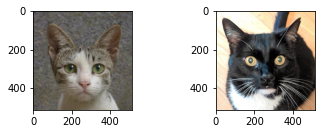

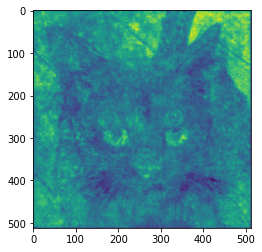

In [7]:
img_index=1000 # the first pair of image trial
plt.subplot(2,2,1)
plt.imshow(left_img[img_index])
plt.subplot(2,2,2)
plt.imshow(right_img[img_index])
plt.show()
plt.imshow(d_vgg_s_clean[img_index])

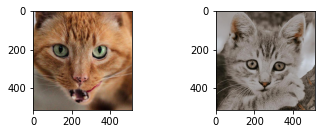

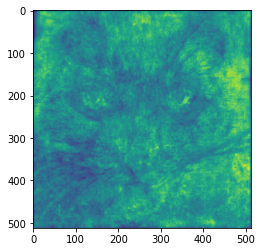

In [8]:
img_index=1 # the first pair of image trial
plt.subplot(2,2,1)
plt.imshow(left_img[img_index])
plt.subplot(2,2,2)
plt.imshow(right_img[img_index])
plt.show()
plt.imshow(d_vgg_s_clean[img_index])

In [9]:
del left_img
del right_img

Here we check the quantities of each classes.

We can see Eddy's behavior data is slightly class imbalance.

In [10]:
print(np.count_nonzero(target ==1))
print(np.count_nonzero(target ==0))

626
599


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(512,512,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,kernel_size=(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
#now flaten the layer and a1dd hiden layers
model.add(Flatten())
# First hiden layer:
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
# Third hiden layer:
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))
# Fourth hiden layer:
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
# Output layer:
model.add(Dense(2,activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

In [14]:
#one-hot encoding for targets
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# transform data
y_2d=np.asarray(target).astype('float32').reshape((-1,1))
y_onehot = encoder.fit_transform(y_2d)
print(y_onehot)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


Import and pre-processing the testing and validation data, the label is one-hot encoded. For the tesing and validataion data, I use the fisrt random sampled cat face expreiment pair image with the same oberser's behavior data.

In [15]:
# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# data_train, data_test, y_train, y_test = train_test_split(d_vgg_s_clean, y_onehot, random_state = 20211001, test_size = 0.2)
data_train=d_vgg_s_clean
y_train=y_onehot
data_test=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s.npy',allow_pickle=True)[:300]
y_test=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_random.npy',allow_pickle=True)[:300]
encoder = OneHotEncoder(sparse=False)
# transform data
y_test=np.asarray(y_test).astype('float32').reshape((-1,1))
y_test = encoder.fit_transform(y_test)

In [16]:
del d_vgg_s_clean

In [17]:
temp=[]
for d in data_test:
  temp.append(d.data.cpu().numpy().reshape(512,512))
data_test=np.array(temp)

In [18]:
data_test, y_test, data_val, y_val=data_test[:200],y_test[:200],data_test[200:300],y_test[200:300]

In [19]:
data_train[0].shape

(512, 512)

In [20]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully.best.hdf5',
                             verbose = 1,
                             save_best_only = True)

In [21]:
model.compile(loss = 'BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
nn = model.fit(data_train,y_train,
                   batch_size = 64,
                   epochs = 20,
                   validation_data=(data_test,y_test),
                   callbacks = [checkpoint],
                   shuffle=True)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 2.5812 - accuracy: 0.4882
Epoch 00001: val_loss improved from inf to 1.15505, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully.best.hdf5
20/20 [==============================] - 64s 2s/step - loss: 2.5812 - accuracy: 0.4882 - val_loss: 1.1551 - val_accuracy: 0.5250
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.4800
Epoch 00002: val_loss improved from 1.15505 to 0.69544, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully.best.hdf5
20/20 [==============================] - 23s 1s/step - loss: 0.8791 - accuracy: 0.4800 - val_loss: 0.6954 - val_accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.4873
Epoch 00003: val_loss did not improve from 0.69544
20/20 [==============================] - 20s 997ms/step - loss: 0

In [22]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

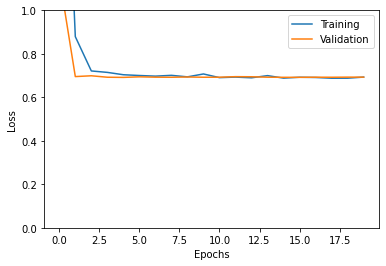

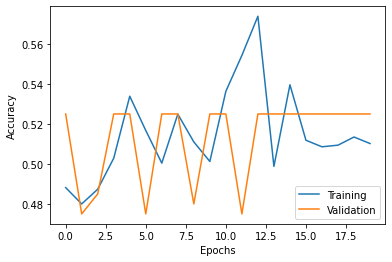

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def nn_hisotry(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylim((0, 1))

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

nn_hisotry(nn)

In [24]:
import pandas as pd
table={'title':['Accurancy','Val_accurancy'],'value':[max(nn.history['accuracy']),max(nn.history['val_accuracy'])]}
pd.DataFrame(table)

,title,value
0,Accurancy,0.573878
1,Val_accurancy,0.525000


In [25]:
from keras.models import load_model
model = load_model(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully.best.hdf5')
model.evaluate(data_val,y_val)

4/4 [==============================] - 4s 682ms/step - loss: 0.6853 - accuracy: 0.5700


[0.6853479743003845, 0.5699999928474426]

In [26]:
predicted_classes = np.argmax(model.predict(data_test),axis=1)

# see which we predicted correctly and which not
y_test_clean=[np.argmax(i) for i in y_test]
correct_indices = np.nonzero(predicted_classes == y_test_clean)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test_clean)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print(predicted_classes)
print(y_test_clean)


105  classified correctly
95  classified incorrectly
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0